In [1]:
#colab
!git clone --single-branch --branch torch https://github.com/lacykaltgr/mei.git
!cp mei/mei.py .
!cp mei/utils.py .

Cloning into 'mei'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 31 (delta 7), reused 19 (delta 4), pack-reused 0
Unpacking objects: 100% (31/31), 46.42 KiB | 1.13 MiB/s, done.


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class Classifier(nn.Module):
    def __init__(self, KERNEL_SIZE=(3, 3), INPUT_SHAPE=(3, 32, 32)):
        super(Classifier, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, KERNEL_SIZE, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, KERNEL_SIZE, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout2d(0.25)

        self.conv3 = nn.Conv2d(32, 64, KERNEL_SIZE, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, KERNEL_SIZE, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout2d(0.25)

        self.conv5 = nn.Conv2d(64, 128, KERNEL_SIZE, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, KERNEL_SIZE, padding=1)
        self.bn6 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(2)

        self.groupnorm = nn.GroupNorm(32, 128)
        self.activation = nn.SiLU()
        self.zeropad1 = nn.ZeroPad2d((1, 1, 1, 1))
        self.conv7 = nn.Conv2d(128, 16, 3, stride=1)
        self.zeropad2 = nn.ZeroPad2d((1, 1, 1, 1))
        self.conv8 = nn.Conv2d(16, 8, 1, stride=1)

        self.flatten = nn.Flatten()
        self.dropout3 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(8 * 6 * 6, 128)
        self.dropout4 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = self.bn6(x)
        x = F.relu(x)
        x = self.maxpool3(x)

        x = self.groupnorm(x)
        x = self.activation(x)
        x = self.zeropad1(x)
        x = self.conv7(x)
        x = self.zeropad2(x)
        x = self.conv8(x)

        x = self.flatten(x)
        x = self.dropout3(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout4(x)
        x = self.fc2(x)

        return F.softmax(x, dim=1)

In [4]:



# Load CIFAR-10 trainset
trainset = CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Load CIFAR-10 testset
testset = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

# Set batch size
batch_size = 128

# Create train and test dataloaders
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:05<00:00, 29905953.97it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [70]:
model = Classifier().to(device)

In [71]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [73]:
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(trainloader):
        inputs = (inputs/255).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{len(trainloader)}], Loss: {running_loss/100:.4f}")
            running_loss = 0.0

Epoch [1/10], Step [100/391], Loss: 2.1869
Epoch [1/10], Step [200/391], Loss: 2.1094
Epoch [1/10], Step [300/391], Loss: 2.0868
Epoch [2/10], Step [100/391], Loss: 2.0462
Epoch [2/10], Step [200/391], Loss: 2.0350
Epoch [2/10], Step [300/391], Loss: 2.0306
Epoch [3/10], Step [100/391], Loss: 1.9989
Epoch [3/10], Step [200/391], Loss: 1.9927
Epoch [3/10], Step [300/391], Loss: 1.9779
Epoch [4/10], Step [100/391], Loss: 1.9604
Epoch [4/10], Step [200/391], Loss: 1.9547
Epoch [4/10], Step [300/391], Loss: 1.9455
Epoch [5/10], Step [100/391], Loss: 1.9223
Epoch [5/10], Step [200/391], Loss: 1.9361
Epoch [5/10], Step [300/391], Loss: 1.9269
Epoch [6/10], Step [100/391], Loss: 1.9018
Epoch [6/10], Step [200/391], Loss: 1.8926
Epoch [6/10], Step [300/391], Loss: 1.8929
Epoch [7/10], Step [100/391], Loss: 1.8840
Epoch [7/10], Step [200/391], Loss: 1.8834
Epoch [7/10], Step [300/391], Loss: 1.8712
Epoch [8/10], Step [100/391], Loss: 1.8572
Epoch [8/10], Step [200/391], Loss: 1.8575
Epoch [8/10

In [74]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in testloader:
        inputs = (inputs/255).to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 39.17%


In [75]:
import mei
import numpy as np

Mei = mei.MEI(model, trainloader, device=device, iter_n=1000)

[32, 32, 3]
Working with images with mu=0.00370166078209877, sigma=0.02222158946096897


In [76]:
Mei.propogate(1)

Working on neuron_id=1
starting drawing
finished step 0 in octave 0
finished step 10 in octave 0
finished step 20 in octave 0
finished step 30 in octave 0
finished step 40 in octave 0
finished step 50 in octave 0
finished step 60 in octave 0
finished step 70 in octave 0
finished step 80 in octave 0
finished step 90 in octave 0
finished step 100 in octave 0
finished step 110 in octave 0
finished step 120 in octave 0
finished step 130 in octave 0
finished step 140 in octave 0
finished step 150 in octave 0
finished step 160 in octave 0
finished step 170 in octave 0
finished step 180 in octave 0
finished step 190 in octave 0
finished step 200 in octave 0
finished step 210 in octave 0
finished step 220 in octave 0
finished step 230 in octave 0
finished step 240 in octave 0
finished step 250 in octave 0
finished step 260 in octave 0
finished step 270 in octave 0
finished step 280 in octave 0
finished step 290 in octave 0
finished step 300 in octave 0
finished step 310 in octave 0
finished st

100%|██████████| 1000/1000 [00:01<00:00, 561.52it/s]


In [77]:
Mei.mei

array([[[107.28657342, 112.37592503, 130.73515703],
        [137.30840735, 124.99886203, 117.37078063],
        [131.61863881, 122.67156285, 134.8636636 ],
        ...,
        [130.77503219, 117.02735508, 136.38232695],
        [126.75995555, 122.44133937, 120.19346501],
        [134.81004099, 132.9314161 , 108.97057495]],

       [[132.66507169, 132.62338451, 115.690848  ],
        [113.42831477, 132.72473796, 123.15067247],
        [135.35815907, 111.97512264, 123.8240908 ],
        ...,
        [111.8163381 , 126.12057488, 127.27462188],
        [146.48481706, 118.57550978, 132.05162344],
        [129.19026829, 125.77769185, 122.5362694 ]],

       [[119.11061824, 125.47851417, 134.91136189],
        [132.09424376, 119.65799849, 131.89447731],
        [129.91518254, 132.48010517, 132.06878875],
        ...,
        [117.9878095 , 124.3856308 , 123.29384331],
        [122.86737976, 123.8720495 , 125.07431561],
        [121.14438195, 130.14869369, 127.47156723]],

       ...,

      

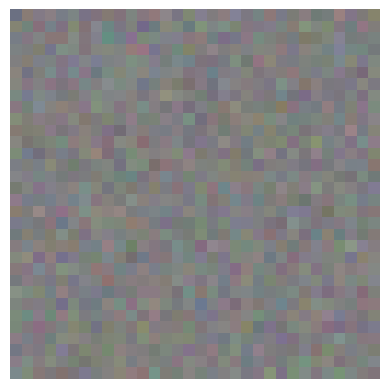

In [78]:
import matplotlib.pyplot as plt

plt.imshow(Mei.mei/255, cmap='gray')
plt.axis('off')
plt.show()

In [79]:
Mei.mei.shape

(32, 32, 3)

In [81]:
y = model(torch.tensor(np.moveaxis(Mei.mei, -1, -3)).float().unsqueeze(0).to(device))

In [82]:
print(np.argmax(y.cpu().detach().numpy()))
print(y)

0
tensor([[1.0000e+00, 1.3645e-11, 1.4854e-09, 1.6196e-09, 1.1641e-09, 1.5210e-15,
         2.9764e-16, 1.6118e-14, 3.7889e-07, 1.3219e-13]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


In [ ]:
import importlib
importlib.reload(mei)

<module 'mei' from '/Users/laszlofreund/code/ai/mei/torch/mei/mei.py'>